In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:000% !important; }</style>"))

In [ ]:
import os
import re
import sys
import glob
import numpy as np
import pandas as pd
from scipy import sparse, io
import matplotlib
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
from sklearn.decomposition import TruncatedSVD

In [2]:
matplotlib.rcParams.update({'font.size': 12})
# %config InlineBackend.figure_format = 'retina'
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_01_qc.html
# https://eleozzr.github.io/desc/tutorial.html

In [46]:
arg_keys = {
    'work_dir': "--work_dir=",
}
args = dict()
for argv in sys.argv[1:]:
    for k, arg_key in arg_keys.items():
        if argv.find(arg_key) == 0:
            args[k] = argv[len(arg_key):]
print(args)

In [27]:
# work_dir = 'D:/Document/Programming/Python/deepbio/symphony/github/scanalysis/scqqapy/data/h5/sarcoma/'
# cell_cycle_gene_fpn = 'D:\Document\Programming\Python\deepbio\symphony\github\scanalysis\scqqapy\data\h5\sarcoma/regev_lab_cell_cycle_genes.txt',
cnt_mat_dirs = glob.glob(args['work_dir'] + 'kallisto.dir/' + '*/bus/counts_unfiltered/adata.h5ad')
# curat_fpns = [re.search(r'(?!\\).*?(\\)', i.split('kallisto.dir')[1]).group(0) for i in cnt_mat_dirs]
# scrna_fns = [re.sub(r'(\\)', '', i) for i in curat_fpns]
scrna_fns = [re.search(r'(.+(?=\/bus))', i.split('kallisto.dir')[1]).group(0).split('/')[1] for i in cnt_mat_dirs]
t2g_fpn = args['work_dir'] + 'geneset.dir/t2g.txt'
# scrna_fns
f = open("sjf.txt", "w")
f.write("sjf")
f.close()

'119291-CCS-72-snRNAseq_S4'

In [4]:
sc_data_coll = []
for i_batch, batch in enumerate(cnt_mat_dirs):
    d = sc.read_h5ad(batch)
    d.var_names_make_unique()
    d.obs['type']="S" + str(i_batch)
    d.obs['sample']="S" + str(i_batch)
    sc_data_coll.append(d)
sc_data_coll

adata = sc_data_coll[0].concatenate(sc_data_coll[1:])
print(adata.obs['sample'].value_counts())
adata
del(sc_data_coll)

D:\Programming\anaconda3\envs\scanal\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


S0    150674
S2    147367
S3    140672
S1    122586
Name: sample, dtype: int64


## QC

In [5]:
def scatter(x, y, x_label="SVD 1", y_label="SVD 2", legend=''):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(x, y, alpha=0.15, c="seagreen", label=legend)
    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.legend(fontsize=18)
    plt.show()

    
def knee(cell_orders, knees, cell_num_cutoff, umi_num_cutoff, x_label="UMI Counts", y_label="Number of cells", legend=''):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.loglog(cell_orders, knees, linewidth=5, color="seagreen", label=legend)
    ax.axhline(umi_num_cutoff, linewidth=3, color="k")
    ax.axvline(cell_num_cutoff, linewidth=3, color="k")
    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.text(
        x=cell_num_cutoff,
        y=umi_num_cutoff,
        s='suggested cutoff:\n {}'.format(cell_num_cutoff),
        color='k',
        weight='bold',
        backgroundcolor='#f0f0f0',
        fontsize=10,
    )
    plt.grid(True, which="both")
    plt.legend(fontsize=18)
    plt.show()
    

def console(adata):
    print('remaining cells: {}, remaining genes: {}'.format(adata.X.shape[0], adata.X.shape[1]))

In [6]:
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

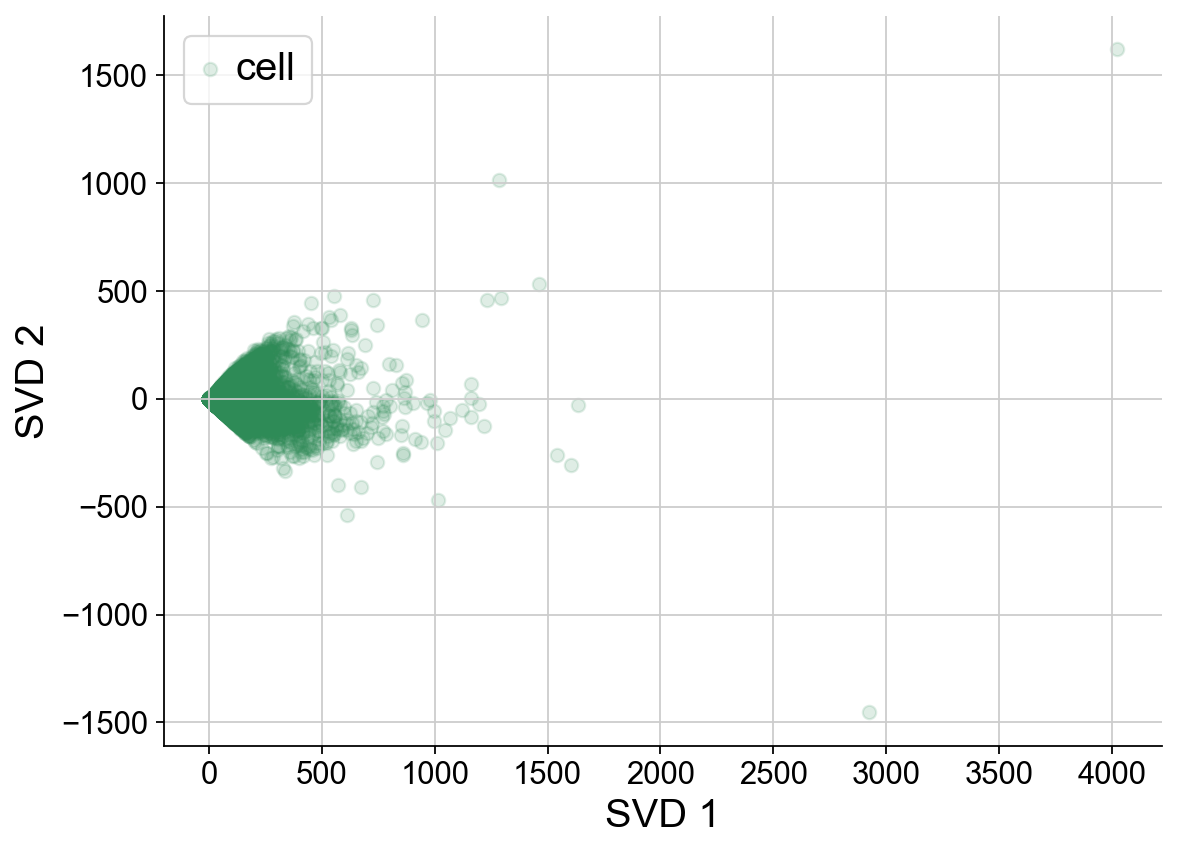

In [7]:
scatter(x=X[:,0], y=X[:,1], x_label="SVD 1", y_label="SVD 2", legend='cell')
plt.savefig(args['work_dir'] + "SVD.png", bbox_inches="tight")

In [8]:
# UMI counts vs. genes detected
num_umis = np.array(adata.X.sum(axis=1)).flatten()
num_gene_expressed = np.array((adata.X>0).sum(axis=1)).flatten()
cell_orders = np.arange(0, adata.X.shape[0])
gene_orders = np.arange(0, adata.X.shape[1])

In [9]:
scatter(x=num_umis, y=num_gene_expressed, x_label="UMI counts", y_label="Number of genes expressed", legend='cell')

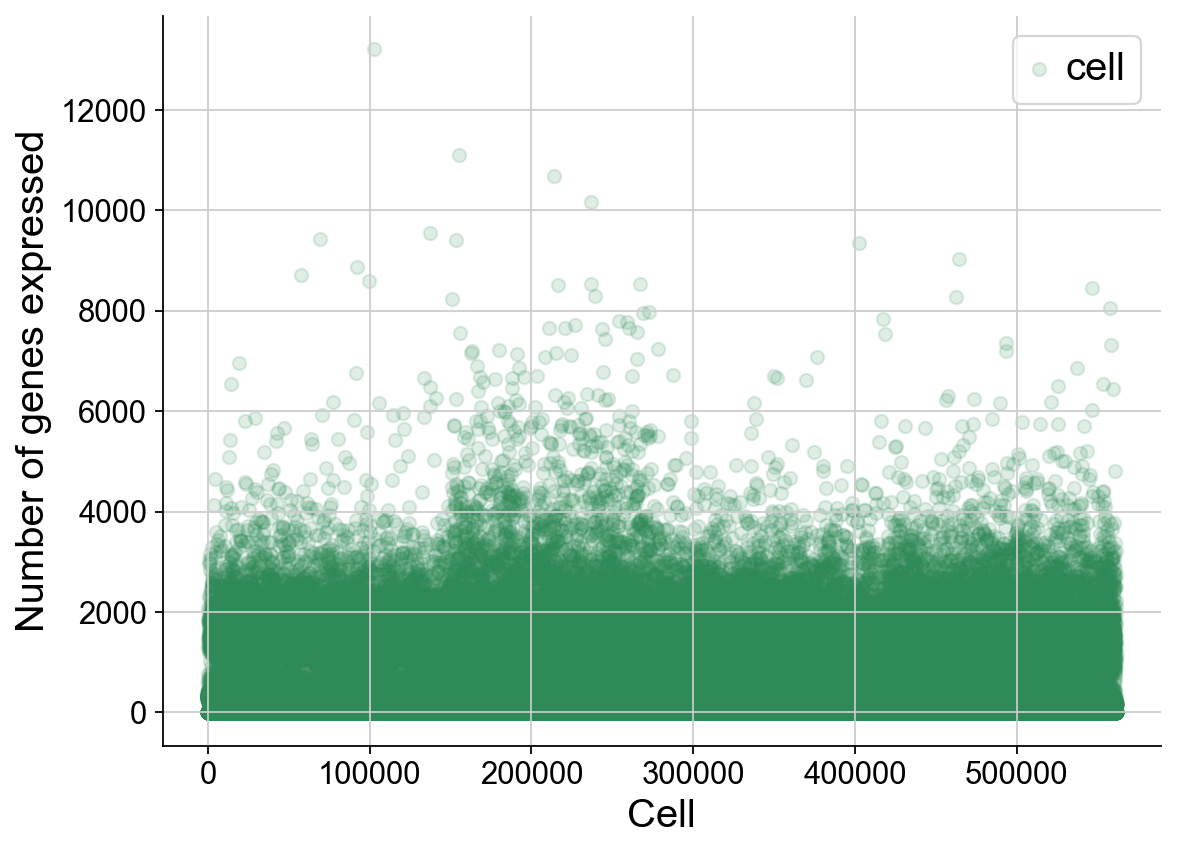

In [10]:
scatter(x=cell_orders, y=num_gene_expressed, x_label="Cell", y_label="Number of genes expressed", legend='cell')

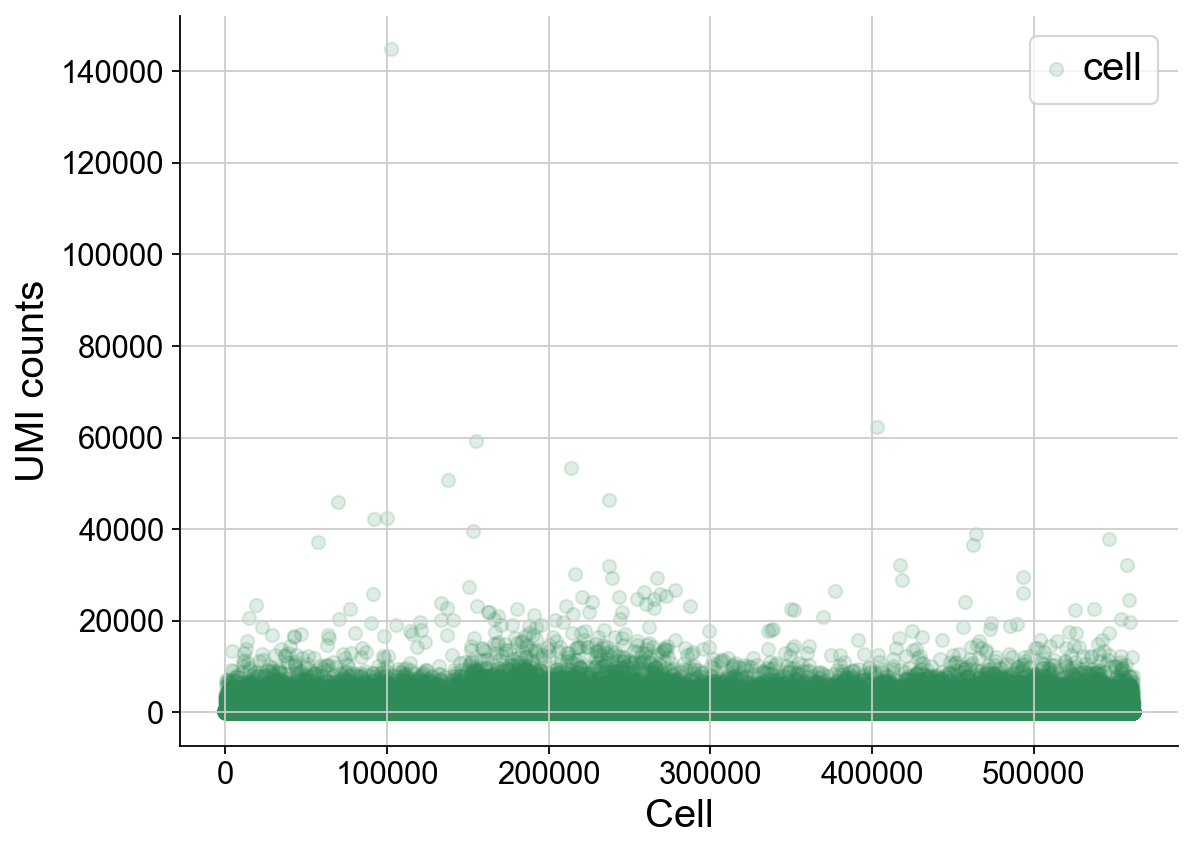

In [11]:
scatter(x=cell_orders, y=num_umis, x_label="Cell", y_label="UMI counts", legend='cell')

In [12]:
umi_num_cutoff =  800
knees = np.sort(num_umis)[::-1]
cell_num_cutoff = cell_orders[knees > umi_num_cutoff][::-1].shape[0]

In [14]:
knee(cell_orders, knees, cell_num_cutoff, umi_num_cutoff, x_label="Number of barcodes", y_label="UMI counts", legend='cell')

In [15]:
console(adata)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=knees[cell_num_cutoff])
console(adata)
sc.pp.filter_genes(adata, min_cells=3)
console(adata)

remaining cells: 561299, remaining genes: 61552
filtered out 337040 cells that have less than 200 genes expressed
filtered out 191636 cells that have less than 800.0 counts
remaining cells: 32623, remaining genes: 61552
filtered out 27012 genes that are detected in less than 3 cells
remaining cells: 32623, remaining genes: 34540


In [16]:
# ribosomal
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_csv(ribo_url, comment='>')
ribo_genes.columns = ['gene_name']
ribo_bools = adata.var['gene_name'].apply(lambda x: True if x in ribo_genes['gene_name'].values else False)
adata.obs['pct_ribo'] = adata[:, adata.var.index[ribo_bools].tolist()].X.sum(axis=1).A1 / adata.X.sum(axis=1).A1
adata.obs

type sample batch  n_genes  n_counts  pct_ribo
barcode                                                          
AAACCCACATCATCCC-0   S0     S0     0      664     863.0  0.135574
AAACCCAGTAGAGTTA-0   S0     S0     0     1810    3474.0  0.036280
AAACCCAGTATGTCTG-0   S0     S0     0      612     800.0  0.177500
AAACCCAGTGGAGAAA-0   S0     S0     0      768    1105.0  0.054299
AAACCCATCACTTGTT-0   S0     S0     0     1854    3264.0  0.025429
...                 ...    ...   ...      ...       ...       ...
TTTGTTGGTCTACAGT-3   S3     S3     3     2504    4473.0  0.033758
TTTGTTGTCACGGAGA-3   S3     S3     3     1984    3421.0  0.036247
TTTGTTGTCGAAATCC-3   S3     S3     3     1765    2987.0  0.028791
TTTGTTGTCGCCAGTG-3   S3     S3     3     1421    2198.0  0.037307
TTTGTTGTCGCTGATA-3   S3     S3     3     3212    6740.0  0.024777

[32623 rows x 6 columns]

In [17]:
# Hemoglobin
hb_bools = adata.var['gene_name'].str.contains(("^HB[^(P)]"))
adata.obs['pct_hb'] = adata[:, adata.var.index[hb_bools].tolist()].X.sum(axis=1).A1 / adata.X.sum(axis=1).A1
adata.obs

type sample batch  n_genes  n_counts  pct_ribo    pct_hb
barcode                                                                    
AAACCCACATCATCCC-0   S0     S0     0      664     863.0  0.135574  0.000000
AAACCCAGTAGAGTTA-0   S0     S0     0     1810    3474.0  0.036280  0.000000
AAACCCAGTATGTCTG-0   S0     S0     0      612     800.0  0.177500  0.000000
AAACCCAGTGGAGAAA-0   S0     S0     0      768    1105.0  0.054299  0.000000
AAACCCATCACTTGTT-0   S0     S0     0     1854    3264.0  0.025429  0.000000
...                 ...    ...   ...      ...       ...       ...       ...
TTTGTTGGTCTACAGT-3   S3     S3     3     2504    4473.0  0.033758  0.000000
TTTGTTGTCACGGAGA-3   S3     S3     3     1984    3421.0  0.036247  0.000292
TTTGTTGTCGAAATCC-3   S3     S3     3     1765    2987.0  0.028791  0.000000
TTTGTTGTCGCCAGTG-3   S3     S3     3     1421    2198.0  0.037307  0.000000
TTTGTTGTCGCTGATA-3   S3     S3     3     3212    6740.0  0.024777  0.000148

[32623 rows x 7 columns]

In [19]:
# mitochondrial
mito_ensembl_ids = sc.queries.mitochondrial_genes("mmusculus", attrname="ensembl_gene_id")
mito_genes = mito_ensembl_ids["ensembl_gene_id"].values
mito_bools = adata.var_names.to_series().apply(lambda x: True if x in mito_genes else False)
adata.obs['pct_mito'] = np.sum(adata[:, adata.var.index[mito_bools].tolist()].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs

type sample batch  n_genes  n_counts  pct_ribo    pct_hb  \
barcode                                                                       
AAACCCACATCATCCC-0   S0     S0     0      664     863.0  0.135574  0.000000   
AAACCCAGTAGAGTTA-0   S0     S0     0     1810    3474.0  0.036280  0.000000   
AAACCCAGTATGTCTG-0   S0     S0     0      612     800.0  0.177500  0.000000   
AAACCCAGTGGAGAAA-0   S0     S0     0      768    1105.0  0.054299  0.000000   
AAACCCATCACTTGTT-0   S0     S0     0     1854    3264.0  0.025429  0.000000   
...                 ...    ...   ...      ...       ...       ...       ...   
TTTGTTGGTCTACAGT-3   S3     S3     3     2504    4473.0  0.033758  0.000000   
TTTGTTGTCACGGAGA-3   S3     S3     3     1984    3421.0  0.036247  0.000292   
TTTGTTGTCGAAATCC-3   S3     S3     3     1765    2987.0  0.028791  0.000000   
TTTGTTGTCGCCAGTG-3   S3     S3     3     1421    2198.0  0.037307  0.000000   
TTTGTTGTCGCTGATA-3   S3     S3     3     3212    6740.0  0.024777  0.000148   

                    pct_mito  
barcode                       
AAACCCACATCATCCC-0       0.0  
AAACCCAGTAGAGTTA-0       0.0  
AAACCCAGTATGTCTG-0       0.0  
AAACCCAGTGGAGAAA-0       0.0  
AAACCCATCACTTGTT-0       0.0  
...                      ...  
TTTGTTGGTCTACAGT-3       0.0  
TTTGTTGTCACGGAGA-3       0.0  
TTTGTTGTCGAAATCC-3       0.0  
TTTGTTGTCGCCAGTG-3       0.0  
TTTGTTGTCGCTGATA-3       0.0  

[32623 rows x 8 columns]

In [20]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.obs

type sample batch  n_genes  n_counts  pct_ribo    pct_hb  \
barcode                                                                       
AAACCCACATCATCCC-0   S0     S0     0      664     863.0  0.135574  0.000000   
AAACCCAGTAGAGTTA-0   S0     S0     0     1810    3473.0  0.036280  0.000000   
AAACCCAGTATGTCTG-0   S0     S0     0      612     800.0  0.177500  0.000000   
AAACCCAGTGGAGAAA-0   S0     S0     0      768    1105.0  0.054299  0.000000   
AAACCCATCACTTGTT-0   S0     S0     0     1854    3264.0  0.025429  0.000000   
...                 ...    ...   ...      ...       ...       ...       ...   
TTTGTTGGTCTACAGT-3   S3     S3     3     2504    4473.0  0.033758  0.000000   
TTTGTTGTCACGGAGA-3   S3     S3     3     1984    3421.0  0.036247  0.000292   
TTTGTTGTCGAAATCC-3   S3     S3     3     1765    2987.0  0.028791  0.000000   
TTTGTTGTCGCCAGTG-3   S3     S3     3     1421    2198.0  0.037307  0.000000   
TTTGTTGTCGCTGATA-3   S3     S3     3     3212    6740.0  0.024777  0.000148   

                    pct_mito  
barcode                       
AAACCCACATCATCCC-0       0.0  
AAACCCAGTAGAGTTA-0       0.0  
AAACCCAGTATGTCTG-0       0.0  
AAACCCAGTGGAGAAA-0       0.0  
AAACCCATCACTTGTT-0       0.0  
...                      ...  
TTTGTTGGTCTACAGT-3       0.0  
TTTGTTGTCACGGAGA-3       0.0  
TTTGTTGTCGAAATCC-3       0.0  
TTTGTTGTCGCCAGTG-3       0.0  
TTTGTTGTCGCTGATA-3       0.0  

[32623 rows x 8 columns]

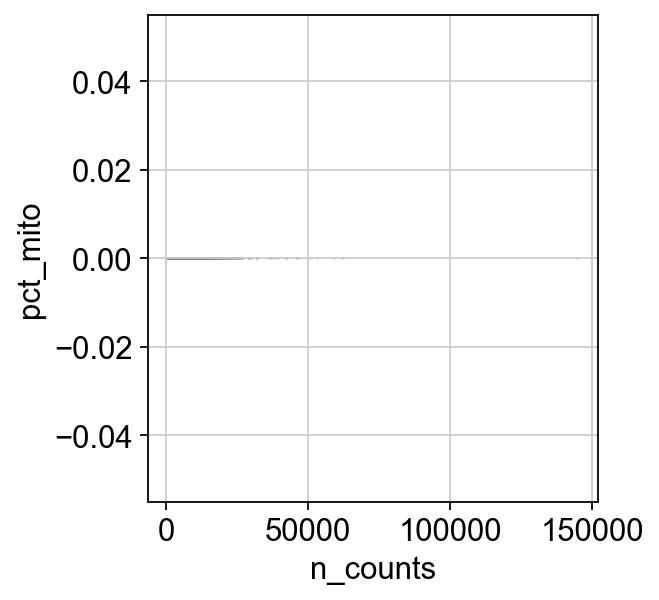

In [21]:
sc.pl.scatter(adata, x='n_counts', y='pct_mito')

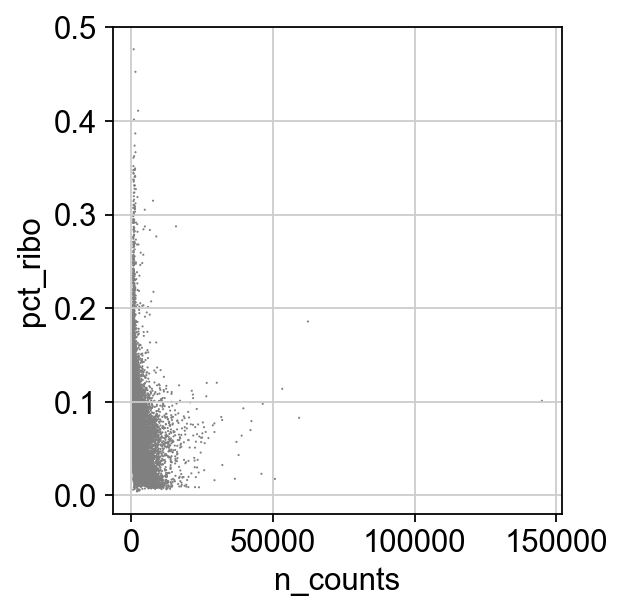

In [22]:
sc.pl.scatter(adata, x='n_counts', y='pct_ribo')

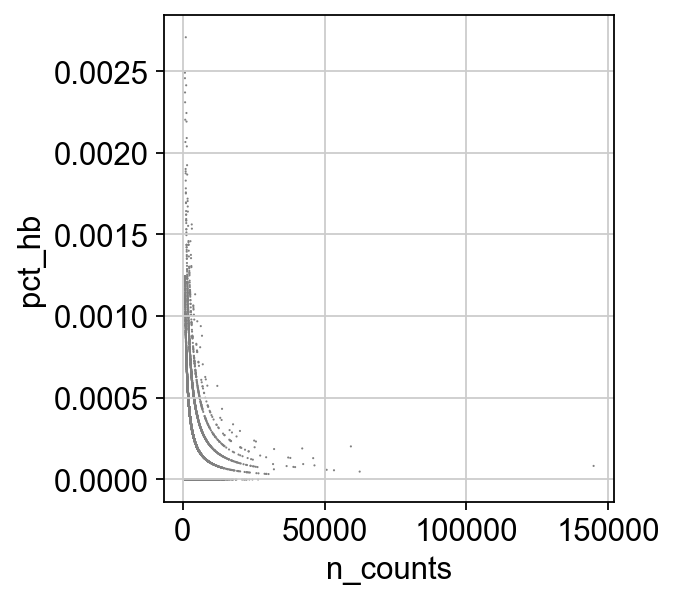

In [23]:
sc.pl.scatter(adata, x='n_counts', y='pct_hb')

In [24]:
adata = adata[adata.obs.pct_mito < 0.03]
console(adata)
adata = adata[adata.obs.pct_ribo > 0.05]
console(adata)

remaining cells: 32623, remaining genes: 34540
remaining cells: 12018, remaining genes: 34540


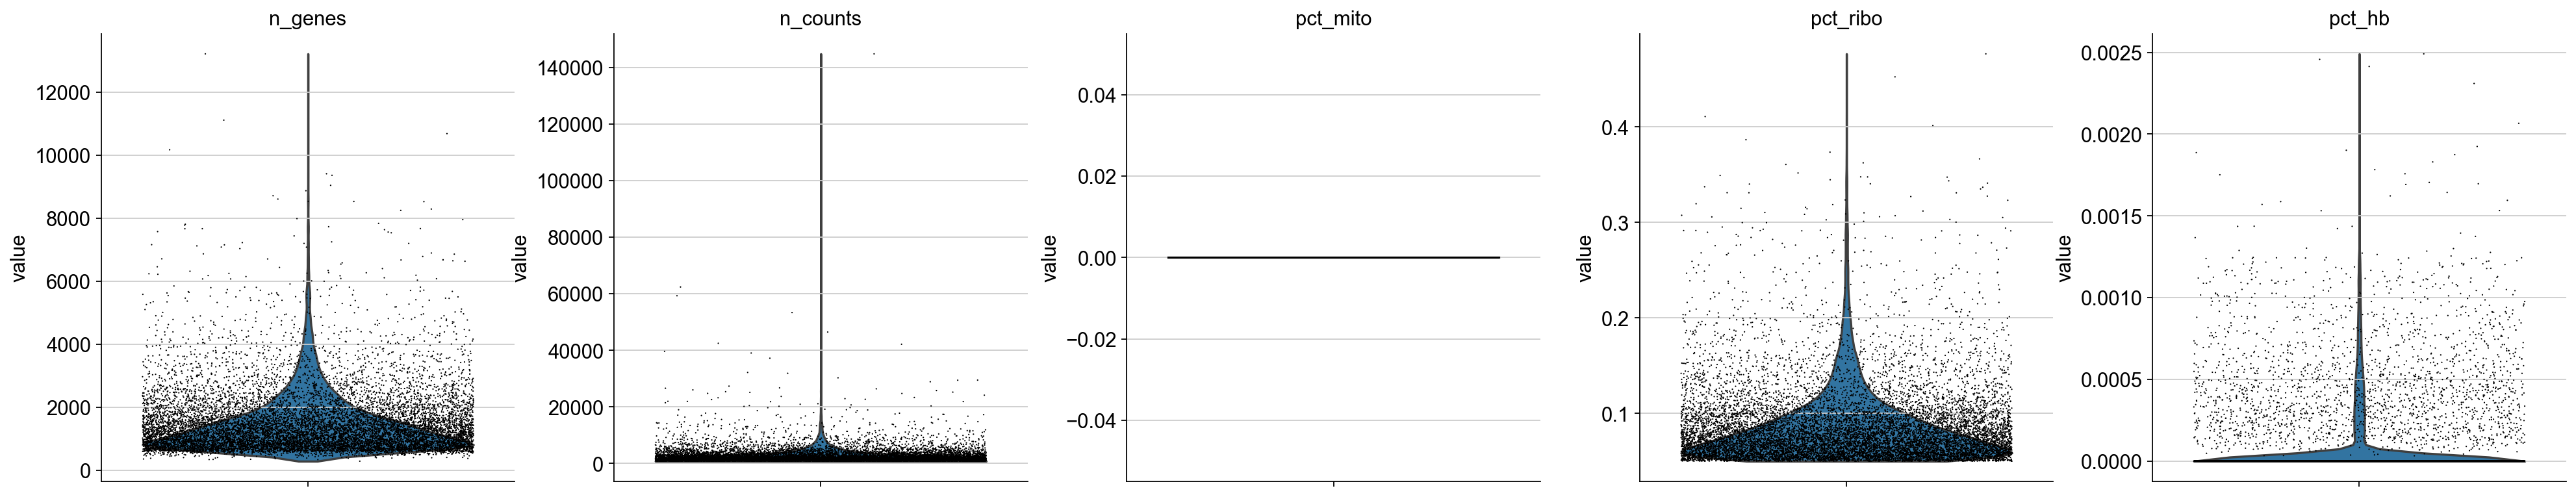

In [25]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'pct_mito', 'pct_ribo', 'pct_hb'], jitter=0.4, multi_panel=True)

In [26]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")
# adata.var[annot.columns] = annot
annot

ensembl_gene_id  start_position  end_position  \
external_gene_name                                                  
MT-TF               ENSG00000210049             577           647   
MT-RNR1             ENSG00000211459             648          1601   
MT-TV               ENSG00000210077            1602          1670   
MT-RNR2             ENSG00000210082            1671          3229   
MT-TL1              ENSG00000209082            3230          3304   
...                             ...             ...           ...   
CFAP141             ENSG00000163263       154199085     154206333   
C1orf43             ENSG00000143612       154206696     154220637   
UBAP2L              ENSG00000143569       154220179     154271510   
SNORA58B            ENSG00000201129       154259727     154259862   
HAX1                ENSG00000143575       154272589     154275875   

                   chromosome_name  
external_gene_name                  
MT-TF                           MT  
MT-RNR1                         MT  
MT-TV                           MT  
MT-RNR2                         MT  
MT-TL1                          MT  
...                            ...  
CFAP141                          1  
C1orf43                          1  
UBAP2L                           1  
SNORA58B                         1  
HAX1                             1  

[68016 rows x 4 columns]

In [27]:
chrY_genes =  pd.Index(adata.var['gene_name']).intersection(annot.index[annot.chromosome_name == "Y"])
chrY_gene_ids = adata.var.loc[adata.var['gene_name'].isin(chrY_genes)].index
chrY_gene_ids
# chrY percentage
adata.obs['pct_chrY'] = np.sum(adata[:, chrY_gene_ids].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs
# XIST counts
adata.obs['cnt_XIST'] = adata.X[:, adata.var['gene_name'].str.match('XIST')].toarray()
adata.obs

C:\Users\jianf\AppData\Local\Temp\ipykernel_10700\2248231679.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['pct_chrY'] = np.sum(adata[:, chrY_gene_ids].X, axis=1) / np.sum(adata.X, axis=1)


type sample batch  n_genes  n_counts  pct_ribo    pct_hb  \
barcode                                                                       
AAACCCACATCATCCC-0   S0     S0     0      664     863.0  0.135574  0.000000   
AAACCCAGTATGTCTG-0   S0     S0     0      612     800.0  0.177500  0.000000   
AAACCCAGTGGAGAAA-0   S0     S0     0      768    1105.0  0.054299  0.000000   
AAACGCTCACTATCCC-0   S0     S0     0      573    1353.0  0.331116  0.000000   
AAAGAACAGAAGTCCG-0   S0     S0     0     1598    2799.0  0.064309  0.000000   
...                 ...    ...   ...      ...       ...       ...       ...   
TTTGGAGCAATGAAAC-3   S3     S3     3      635     821.0  0.137637  0.001218   
TTTGGAGCATATGAAG-3   S3     S3     3      915    1250.0  0.104800  0.000000   
TTTGGAGGTGACAACG-3   S3     S3     3     4818   11987.0  0.084008  0.000083   
TTTGGTTAGTCATGGG-3   S3     S3     3     1130    1530.0  0.069935  0.000000   
TTTGTTGAGTGGTCAG-3   S3     S3     3     1408    2052.0  0.055556  0.000000   

                    pct_mito  pct_chrY  cnt_XIST  
barcode                                           
AAACCCACATCATCCC-0       0.0  0.001159       0.0  
AAACCCAGTATGTCTG-0       0.0  0.001250       0.0  
AAACCCAGTGGAGAAA-0       0.0  0.000000       0.0  
AAACGCTCACTATCCC-0       0.0  0.000000       0.0  
AAAGAACAGAAGTCCG-0       0.0  0.002501       0.0  
...                      ...       ...       ...  
TTTGGAGCAATGAAAC-3       0.0  0.000000       0.0  
TTTGGAGCATATGAAG-3       0.0  0.000000       0.0  
TTTGGAGGTGACAACG-3       0.0  0.001251       0.0  
TTTGGTTAGTCATGGG-3       0.0  0.001961       0.0  
TTTGTTGAGTGGTCAG-3       0.0  0.000975       0.0  

[12018 rows x 10 columns]

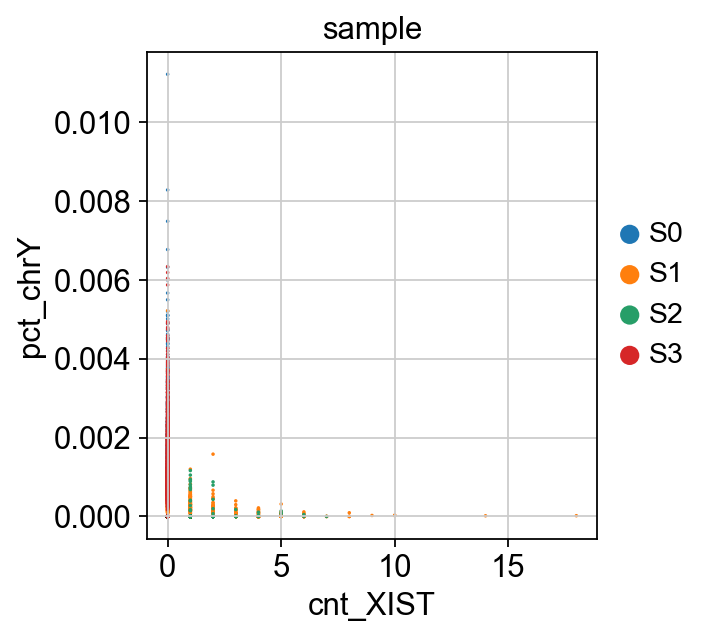

In [28]:
sc.pl.scatter(adata, x='cnt_XIST', y='pct_chrY', color="sample")

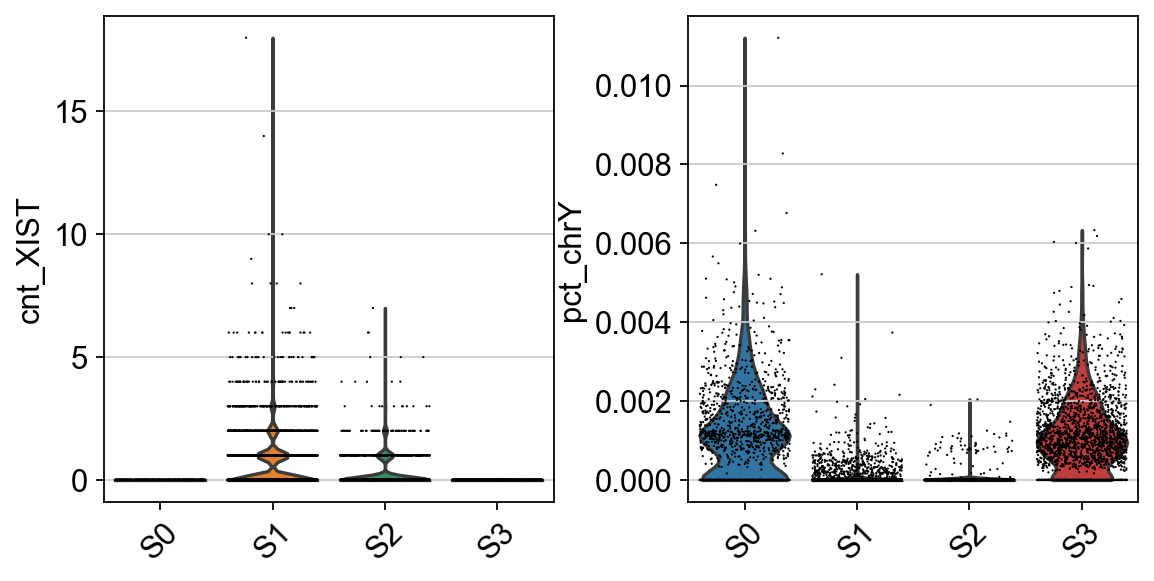

In [29]:
sc.pl.violin(adata, ["cnt_XIST", "pct_chrY"], jitter=0.4, groupby='sample', rotation=45)

In [45]:
cell_cycle_url = "https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt"
cell_cycle_genes = pd.read_csv(cell_cycle_url, comment='>')
cell_cycle_genes.columns = ['gene_name']
cell_cycle_genes
cell_cycle_genes = pd.Index(cell_cycle_genes['gene_name']).intersection(pd.Index(adata.var['gene_name']))
cell_cycle_genes
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_gene_ensembl = adata.var.loc[adata.var['gene_name'].isin(s_genes)].index
g2m_gene_ensembl = adata.var.loc[adata.var['gene_name'].isin(g2m_genes)].index
s_gene_ensembl

Index(['PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6',
       'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'HELLS', 'RFC2', 'RPA2', 'NASP',
       'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2',
       'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1',
       'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8',
       'HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80',
       'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'SMC4',
       'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E',
       'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'CDC20', 'TTK', 'CDC25C',
       'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2',
       'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE',
       'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA'],
      dtype='object', name='gene_name')

In [31]:
# normalize
# adata.raw = None
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


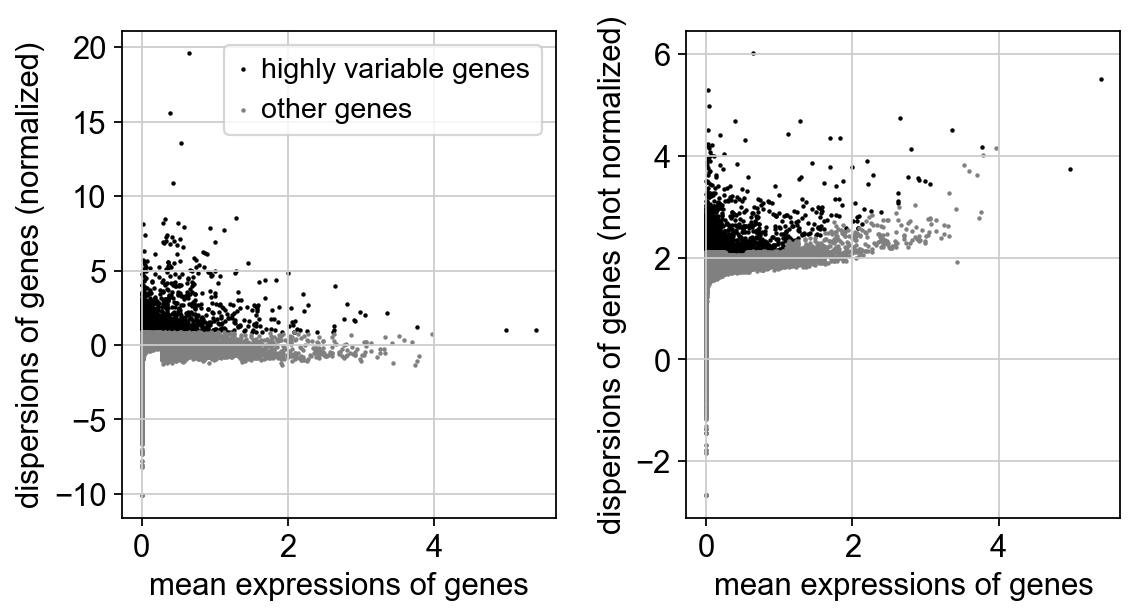

In [32]:
# flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata)

In [33]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [37]:
g2m_gene_ensembl

Index([], dtype='object', name='gene_id')

In [34]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_gene_ensembl, g2m_genes=g2m_gene_ensembl)

calculating cell cycle phase
computing score 'S_score'


ValueError: No valid genes were passed for scoring.

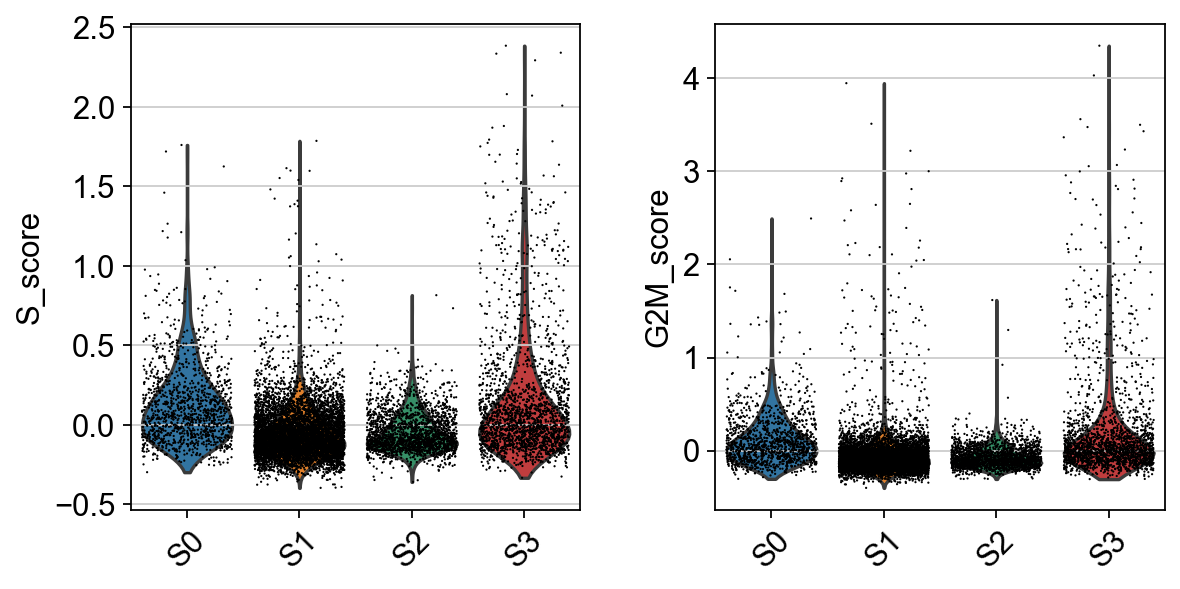

In [45]:
sc.pl.violin(adata, ['S_score', 'G2M_score'], jitter=0.4, groupby = 'sample', rotation=45)

## Doublet

Preprocessing...


D:\Programming\anaconda3\envs\scanal\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 162.9 seconds


0

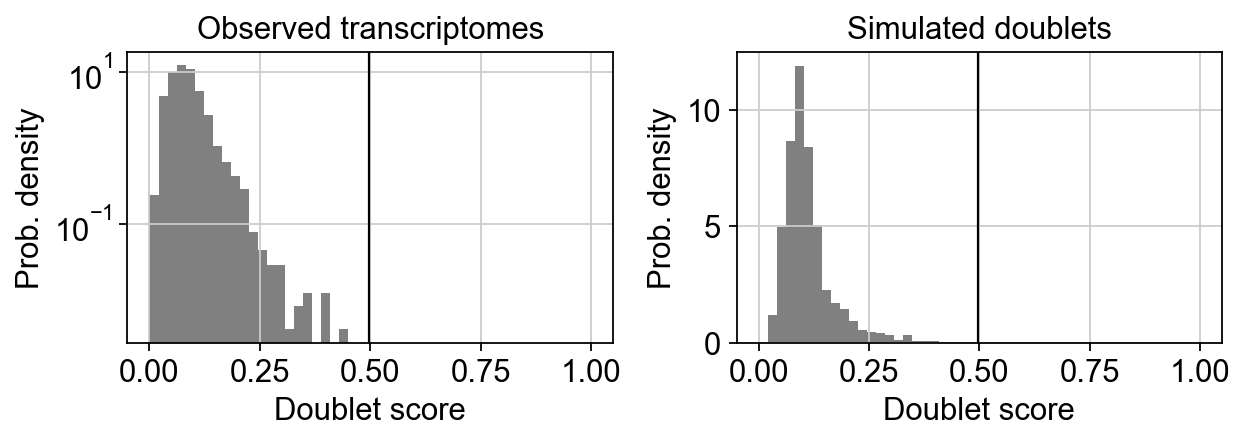

In [47]:
import scrublet as scr
scrub = scr.Scrublet(adata.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()
sum(adata.obs['predicted_doublets'])

In [49]:
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)
adata.obs

type sample batch  n_genes  n_counts  pct_ribo    pct_hb  \
barcode                                                                       
AAACCCACATCATCCC-0   S0     S0     0      664     863.0  0.135574  0.000000   
AAACCCAGTATGTCTG-0   S0     S0     0      612     800.0  0.177500  0.000000   
AAACCCAGTGGAGAAA-0   S0     S0     0      768    1105.0  0.054299  0.000000   
AAACGCTCACTATCCC-0   S0     S0     0      573    1353.0  0.331116  0.000000   
AAAGAACAGAAGTCCG-0   S0     S0     0     1598    2799.0  0.064309  0.000000   
...                 ...    ...   ...      ...       ...       ...       ...   
TTTGGAGCAATGAAAC-3   S3     S3     3      635     821.0  0.137637  0.001218   
TTTGGAGCATATGAAG-3   S3     S3     3      915    1250.0  0.104800  0.000000   
TTTGGAGGTGACAACG-3   S3     S3     3     4818   11987.0  0.084008  0.000083   
TTTGGTTAGTCATGGG-3   S3     S3     3     1130    1530.0  0.069935  0.000000   
TTTGTTGAGTGGTCAG-3   S3     S3     3     1408    2052.0  0.055556  0.000000   

                    pct_mito  pct_chrY  cnt_XIST   S_score  G2M_score phase  \
barcode                                                                       
AAACCCACATCATCCC-0       0.0  0.001159       0.0  0.507736   0.475500     S   
AAACCCAGTATGTCTG-0       0.0  0.001250       0.0  0.100236   0.053033     S   
AAACCCAGTGGAGAAA-0       0.0  0.000000       0.0  0.145884   0.062881     S   
AAACGCTCACTATCCC-0       0.0  0.000000       0.0  0.040041   0.112426   G2M   
AAAGAACAGAAGTCCG-0       0.0  0.002501       0.0 -0.186820  -0.172415    G1   
...                      ...       ...       ...       ...        ...   ...   
TTTGGAGCAATGAAAC-3       0.0  0.000000       0.0  0.387886   1.598900   G2M   
TTTGGAGCATATGAAG-3       0.0  0.000000       0.0 -0.071433   0.081967   G2M   
TTTGGAGGTGACAACG-3       0.0  0.001251       0.0  1.105623   1.109850   G2M   
TTTGGTTAGTCATGGG-3       0.0  0.001961       0.0  0.131467  -0.174440     S   
TTTGTTGAGTGGTCAG-3       0.0  0.000975       0.0  0.094749  -0.161445     S   

                    doublet_scores  predicted_doublets doublet_info  
barcode                                                              
AAACCCACATCATCCC-0        0.154217               False        False  
AAACCCAGTATGTCTG-0        0.031762               False        False  
AAACCCAGTGGAGAAA-0        0.099196               False        False  
AAACGCTCACTATCCC-0        0.019486               False        False  
AAAGAACAGAAGTCCG-0        0.071481               False        False  
...                            ...                 ...          ...  
TTTGGAGCAATGAAAC-3        0.104147               False        False  
TTTGGAGCATATGAAG-3        0.030211               False        False  
TTTGGAGGTGACAACG-3        0.039466               False        False  
TTTGGTTAGTCATGGG-3        0.052038               False        False  
TTTGTTGAGTGGTCAG-3        0.094536               False        False  

[12018 rows x 16 columns]

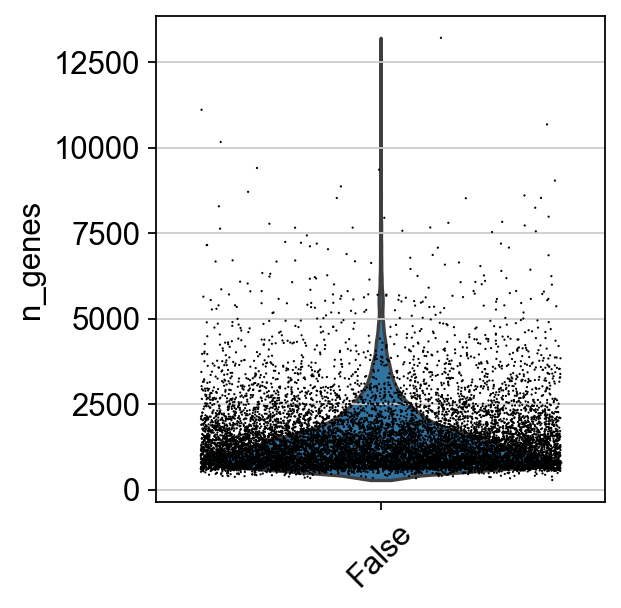

In [51]:
sc.pl.violin(adata, 'n_genes', jitter=0.4, groupby = 'doublet_info', rotation=45)

In [53]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

extracting highly variable genes
    finished (0:00:13)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:20)
computing neighbors
    using 'X_pca' with n_pcs = 40


D:\Programming\anaconda3\envs\scanal\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


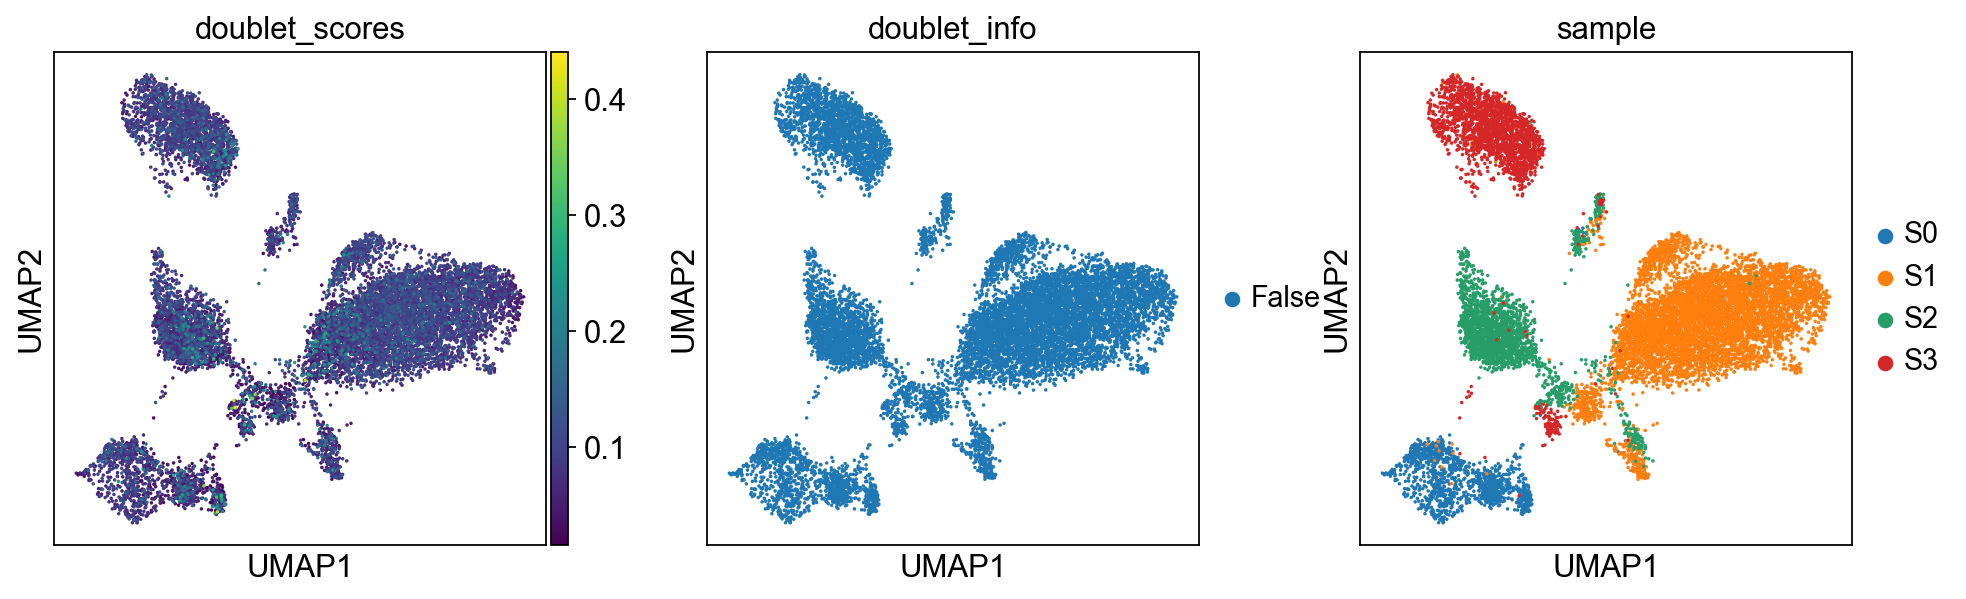

In [55]:
sc.pl.umap(adata, color=['doublet_scores', 'doublet_info', 'sample'])

In [58]:
adata

AnnData object with n_obs × n_vars = 12018 × 11041
    obs: 'type', 'sample', 'batch', 'n_genes', 'n_counts', 'pct_ribo', 'pct_hb', 'pct_mito', 'pct_chrY', 'cnt_XIST', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'log1p', 'hvg', 'doublet_info_colors', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [60]:
adata = adata[adata.obs['doublet_info'] == 'False', :]

## Batch effect

In [61]:
import desc
# https://eleozzr.github.io/desc/tutorial.html
desc.scale(adata, zero_center=True, max_value=3)

D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [62]:
adata = desc.train(
    adata,
    dims=[adata.shape[1], 32, 16],
    tol=0.005,
    n_neighbors=10,
    batch_size=256,
    louvain_resolution=[0.8],
    save_dir="result_pbmc3k",
    do_tsne=True,
    learning_rate=300,
    do_umap=True,
    num_Cores_tsne=4,
    save_encoder_weights=True,
)

Start to process resolution= 0.8
The number of cpu in your computer is 12

Create the directory:result_pbmc3k to save result
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Checking whether result_pbmc3k\ae_weights.h5  exists in the directory
The file ae_weights.h5 is not exits
Pretraining the 1th layer...
learning rate = 0.1
Epoch 1/50
47/47 [==============================] - 2s 38ms/step - loss: 0.1112
Epoch 2/50
47/47 [==============================] - 2s 38ms/step - loss: 0.1111
Epoch 3/50
47/47 [==============================] - 2s 37ms/step - loss: 0.1110
Epoch 4/50
47/47 [==============================] - 2s 39ms/step - loss: 0.1109
Epoch 5/50
47/47 [==============================] - 2s 37ms/step - loss: 0.1109
Epoch 6/50
47/47 [==============================] - 2s 37ms/step - loss: 0.1108
Epoch 7/50
47/47 [==============================] - 2s 38ms/step - loss: 0.110

D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\tools\_tsne.py:113: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  warnings.warn(
D:\Programming\anaconda3\envs\scanal\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:52)
tsne finished and added X_tsne0.8  into the umap coordinates (adata.obsm)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
umap finished and added X_umap0.8  into the umap coordinates (adata.obsm)

The run time for all resolution is: 329.29460763931274
After training, the information of adata is:
 AnnData object with n_obs × n_vars = 12018 × 11041
    obs: 'type', 'sample', 'batch', 'n_genes', 'n_counts', 'pct_ribo', 'pct_hb', 'pct_mito', 'pct_chrY', 'cnt_XIST', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'desc_0.8'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sampl

In [97]:
adata.obsm['X_pca']

array([[ -8.150041  ,  -2.3996577 ,   4.5033236 , ...,   0.98828095,
          0.83464634,   0.7664799 ],
       [-10.195585  ,  -4.8697543 ,   3.8383532 , ...,  -0.8539428 ,
         -0.6442667 ,  -0.8030839 ],
       [ -8.305913  ,   0.72466356,   0.01810373, ...,   1.0511957 ,
          2.1177738 ,   1.0412292 ],
       ...,
       [ 10.5265255 ,   7.315962  ,   8.726663  , ...,   0.45149547,
         -0.393005  ,   0.813893  ],
       [ -0.4556897 ,   5.7121015 ,   3.9799583 , ...,   2.2822235 ,
          0.4623769 ,   0.77889866],
       [  0.55566704,   5.71433   ,   4.508911  , ...,  -2.7891233 ,
          0.50688267,  -0.8236551 ]], dtype=float32)

D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


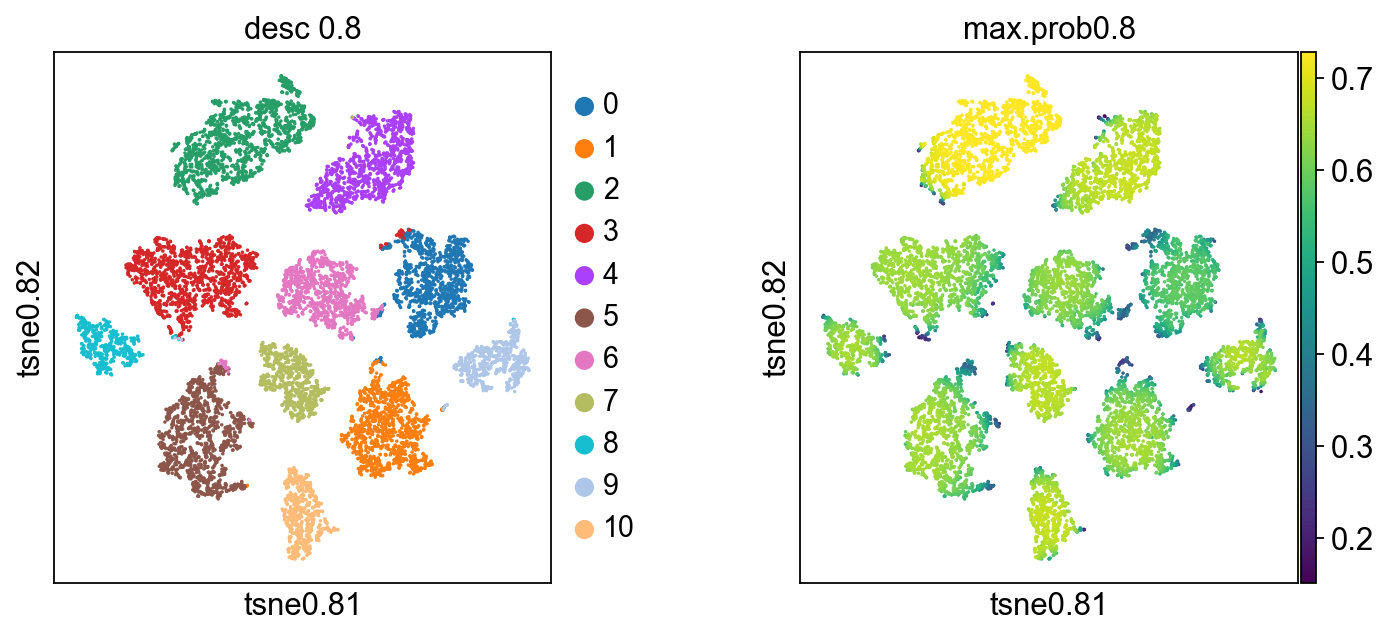

In [64]:
prob_08 = adata.uns["prob_matrix0.8"]
adata.obs["max.prob0.8"] = np.max(prob_08,axis=1)
#tSNE plot 
sc.pl.scatter(adata, basis="tsne0.8", color=['desc_0.8',"max.prob0.8"])

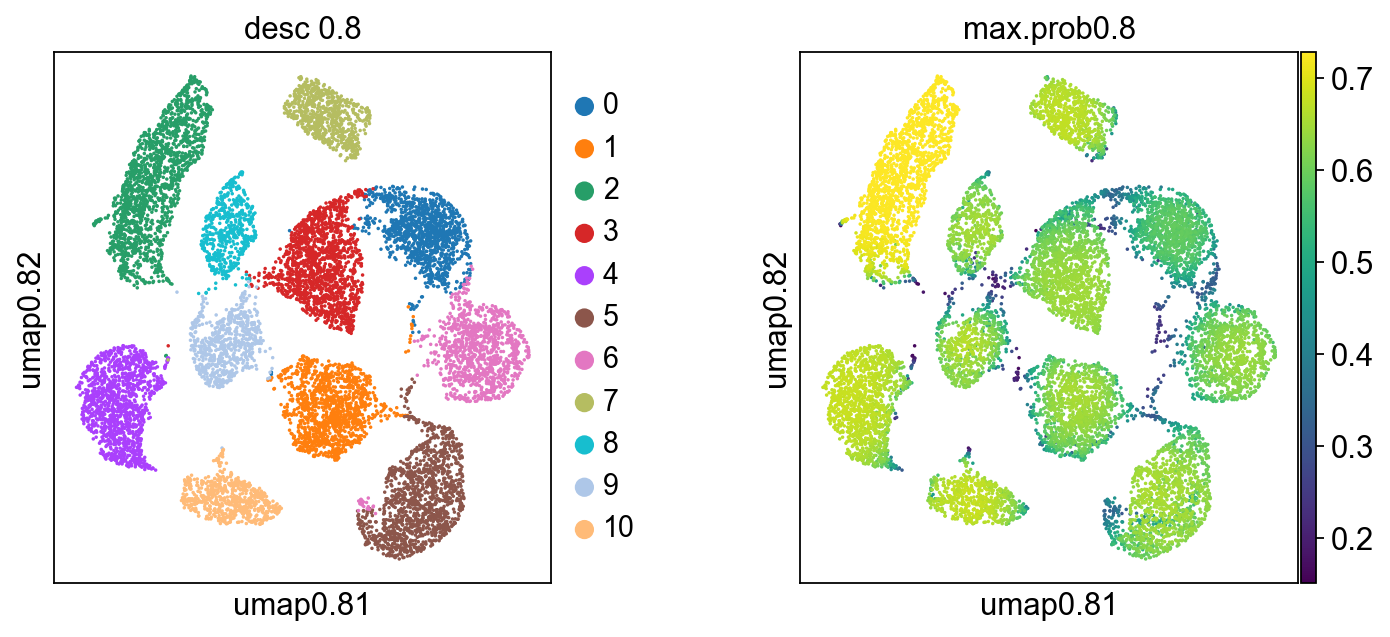

In [65]:
sc.pl.scatter(adata, basis="umap0.8", color=['desc_0.8',"max.prob0.8"])

In [103]:
adata

AnnData object with n_obs × n_vars = 12018 × 11041
    obs: 'type', 'sample', 'batch', 'n_genes', 'n_counts', 'pct_ribo', 'pct_hb', 'pct_mito', 'pct_chrY', 'cnt_XIST', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'desc_0.8', 'max.prob0.8'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'log1p', 'hvg', 'doublet_info_colors', 'pca', 'umap', 'tsne', 'prob_matrix0.8', 'desc_0.8_colors'
    obsm: 'X_pca', 'X_umap', 'X_Embeded_z0.8', 'X_tsne', 'X_tsne0.8', 'X_umap0.8', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
adata.obs["desc_0.8"] = adata.obs["desc_0.8"].astype(str)
sc.pl.stacked_violin(adata, ["MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"], groupby='desc_0.8', figsize=(8,10), swap_axes=True)

In [106]:
adata.obsm['X_pca_harmony'].shape

(12018, 50)

## Clustering

In [102]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata, 'batch')

2022-05-11 21:21:41,550 - harmonypy - INFO - Iteration 1 of 10
2022-05-11 21:21:44,479 - harmonypy - INFO - Iteration 2 of 10
2022-05-11 21:21:47,408 - harmonypy - INFO - Converged after 2 iterations


In [96]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:15)


D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


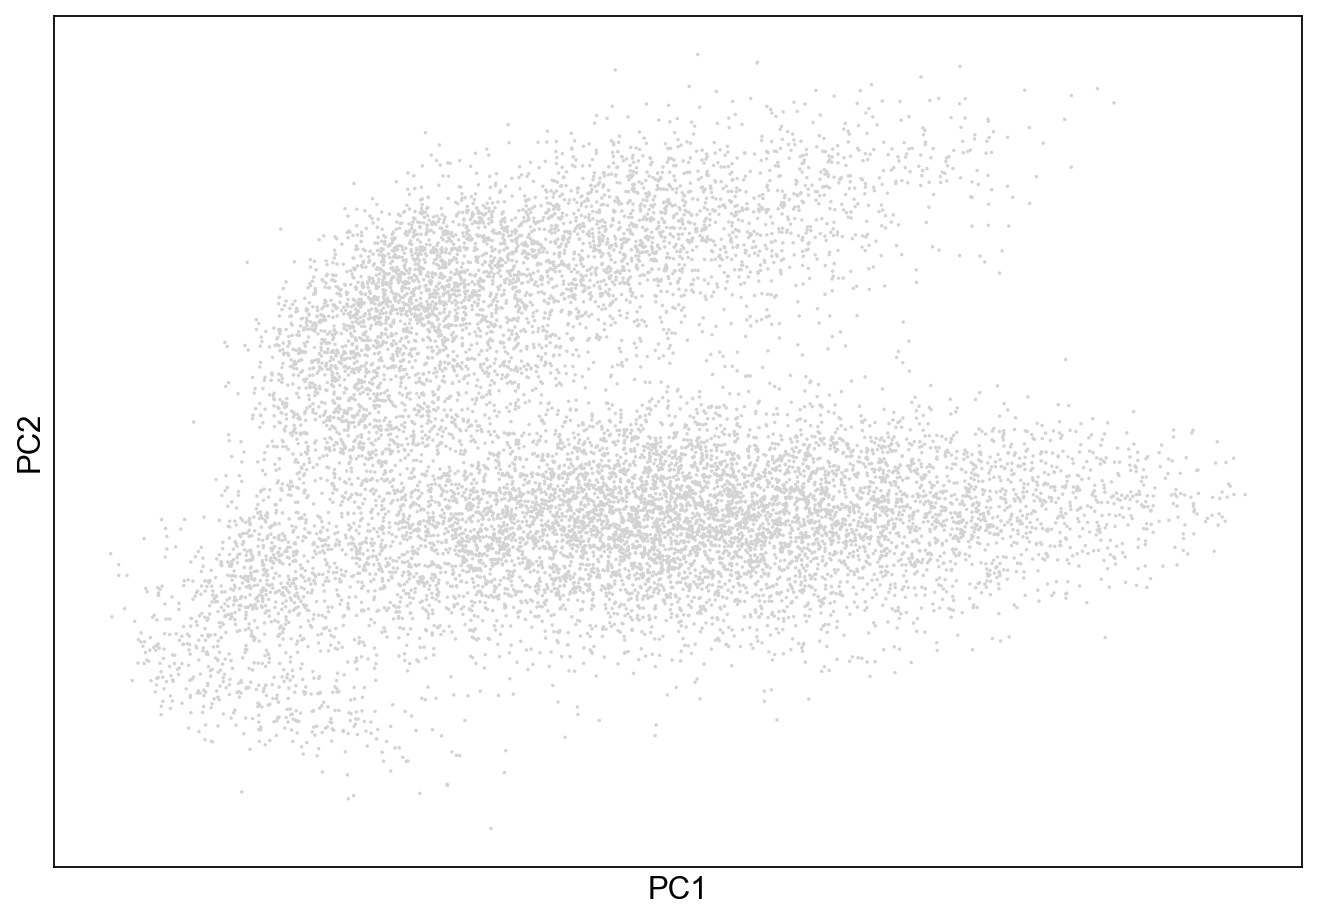

In [101]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata,  ax=ax)

In [109]:
adata
# adata.obsm
# 'X_pca_harmony' in 
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True, use_rep='X_pca_harmony')
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


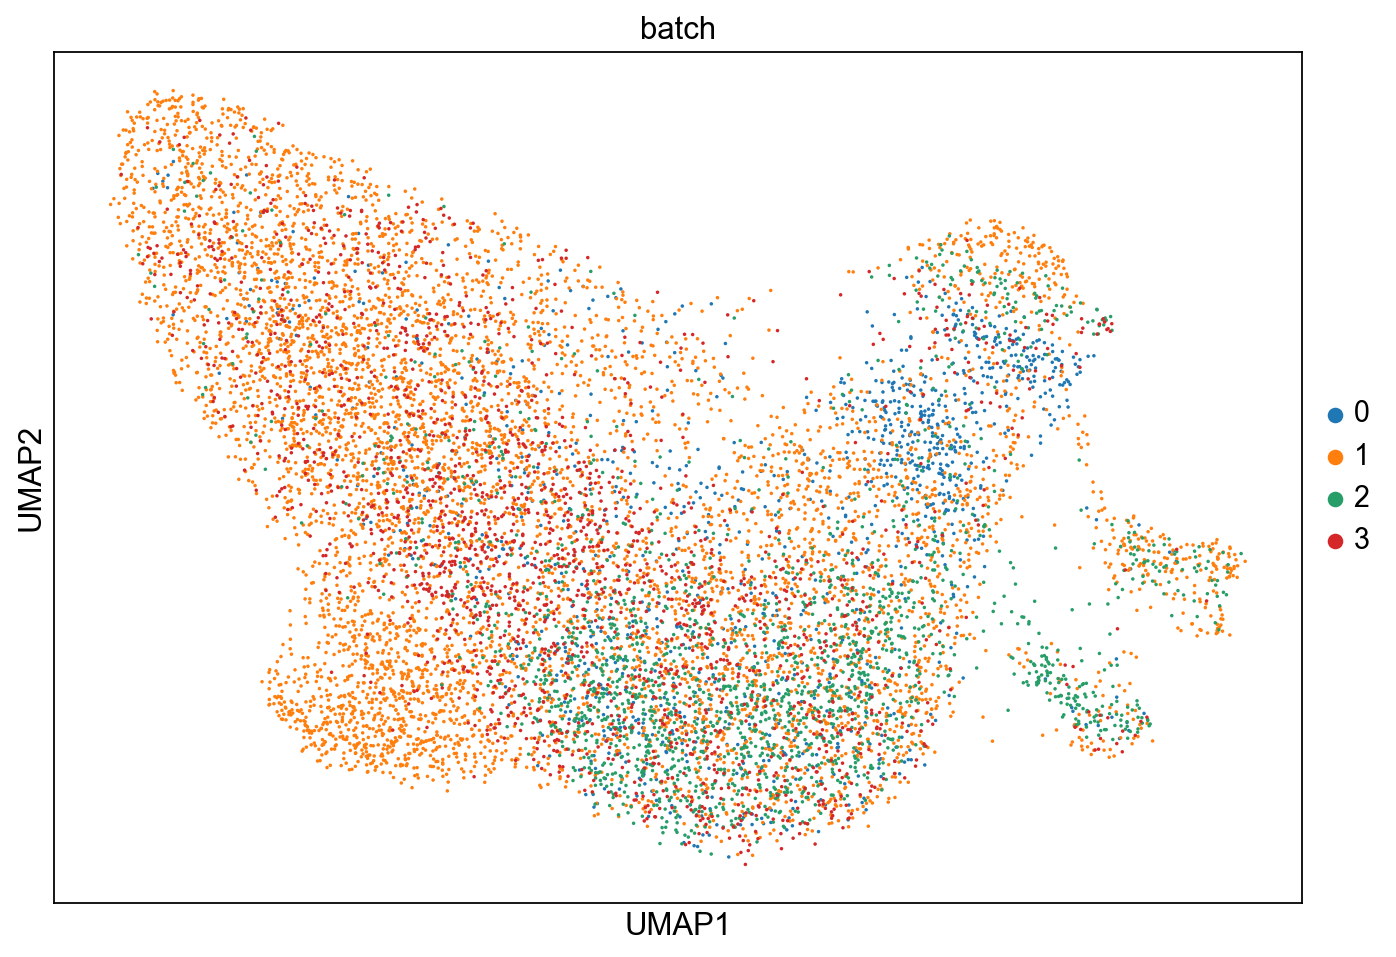

In [110]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='batch', ax=ax)

D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


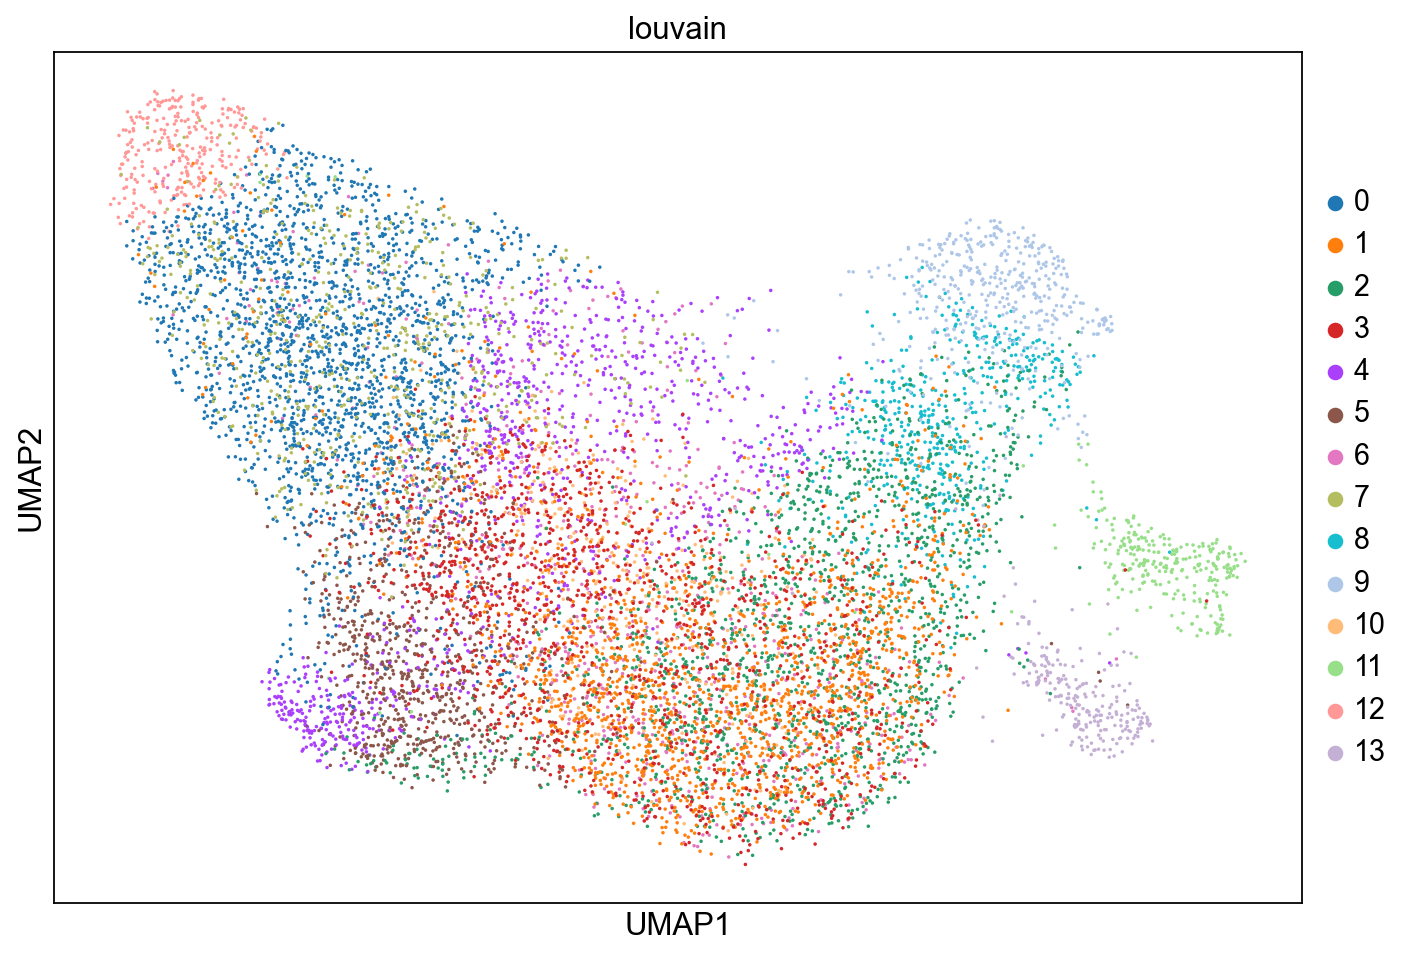

In [116]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)

In [ ]:
# import scrublet as scr
# scrub = scr.Scrublet(adata.X)
# adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
# scrub.plot_histogram()

# sum(adata.obs['predicted_doublets'])

In [111]:
%%time
# Cluster the cells using Louvain clustering
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.louvain(adata)

computing PCA
    on highly variable genes
    with n_comps=10
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
CPU times: total: 29.5 s
Wall time: 6.82 s


D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


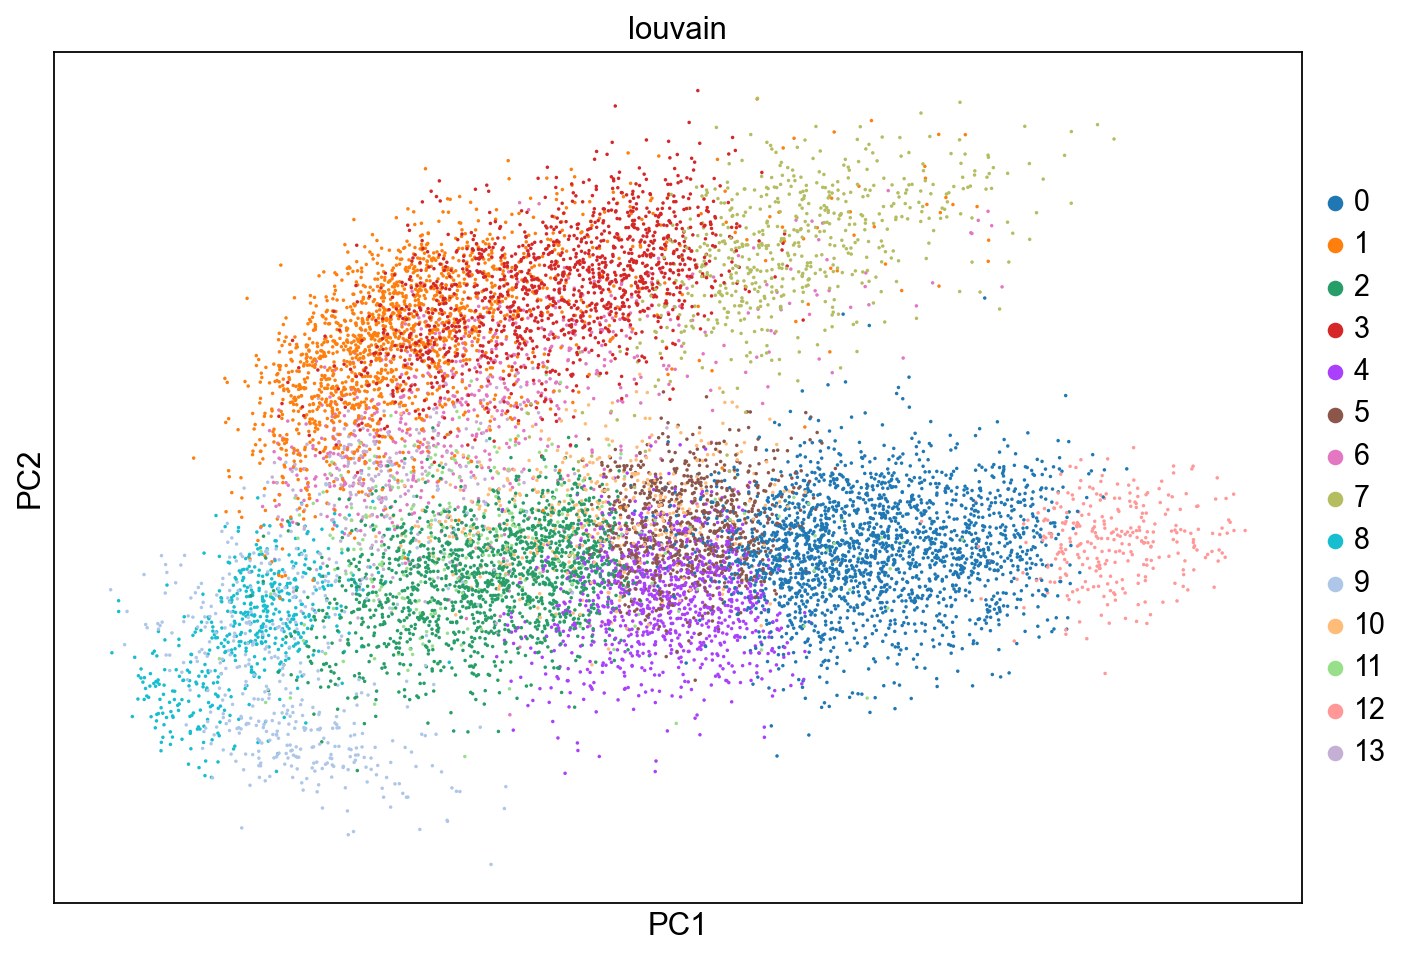

In [115]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

In [113]:
sc.tl.tsne(adata, n_pcs=10)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE


D:\Programming\anaconda3\envs\scanal\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:49)


D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


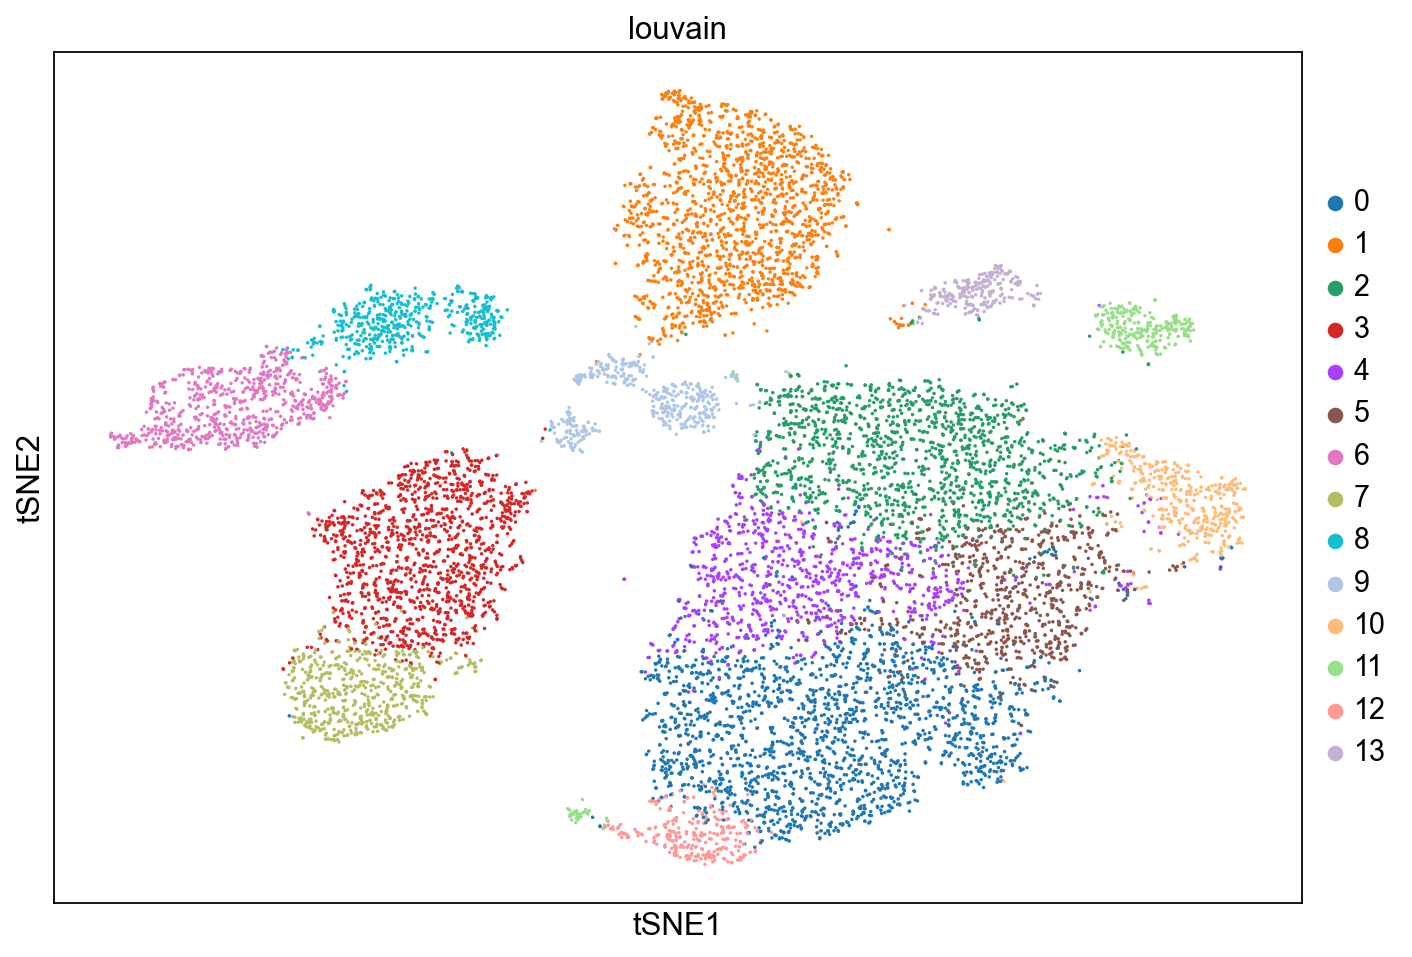

In [114]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax)

In [117]:
%%time
# Visualize cells with t-SNE. The n_pcs parameter sets the number of principal components to project to prior to 
# performing t-SNE
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
CPU times: total: 9.48 s
Wall time: 9.41 s


D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


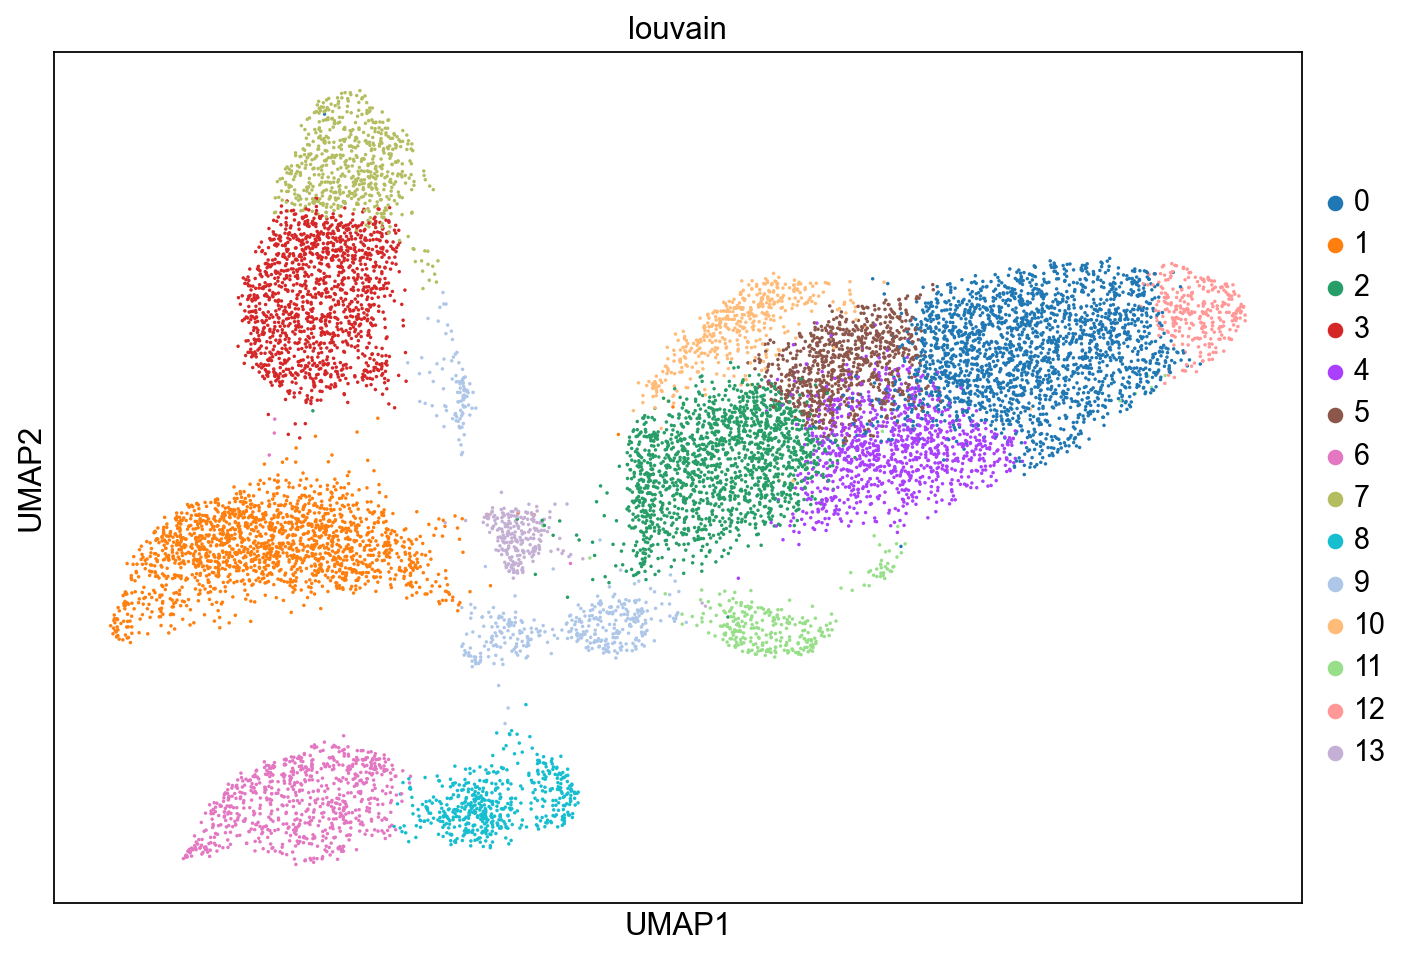

In [138]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)
plt.savefig("asd.pdf", bbox_inches="tight")

In [119]:
sc.external.pp.bbknn(adata, batch_key='batch')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


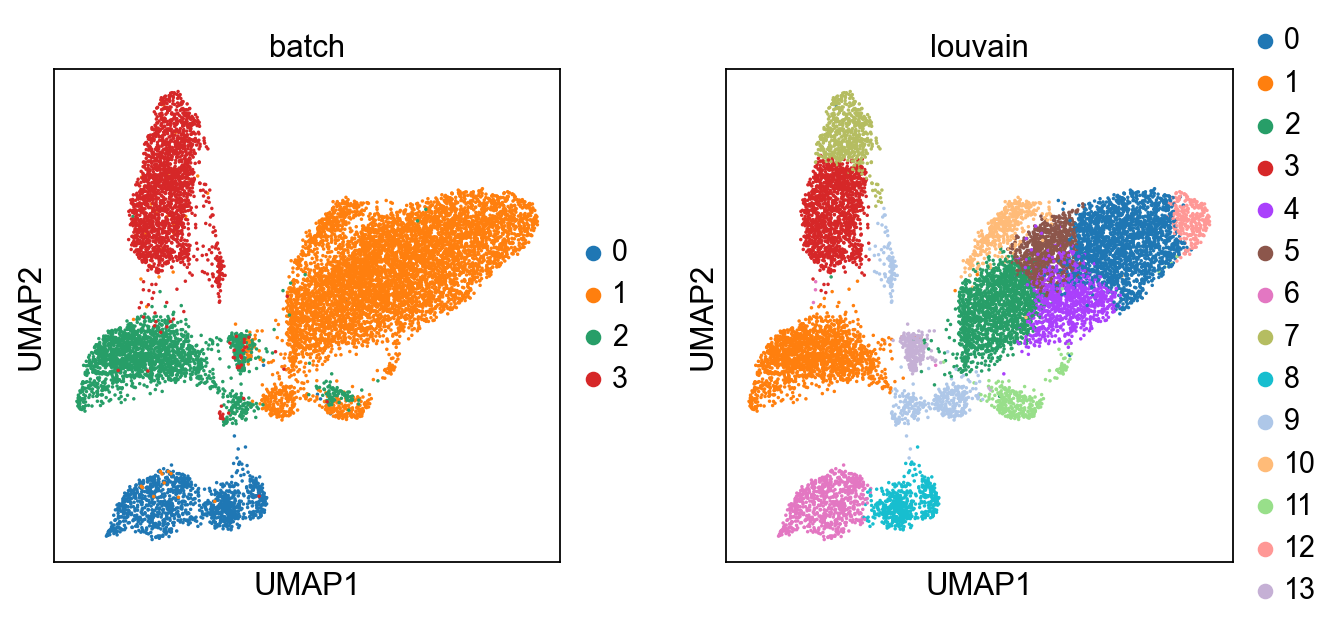

In [137]:
sc.pl.umap(adata, color=['batch', 'louvain'])
plt.savefig("asd.pdf", bbox_inches="tight")